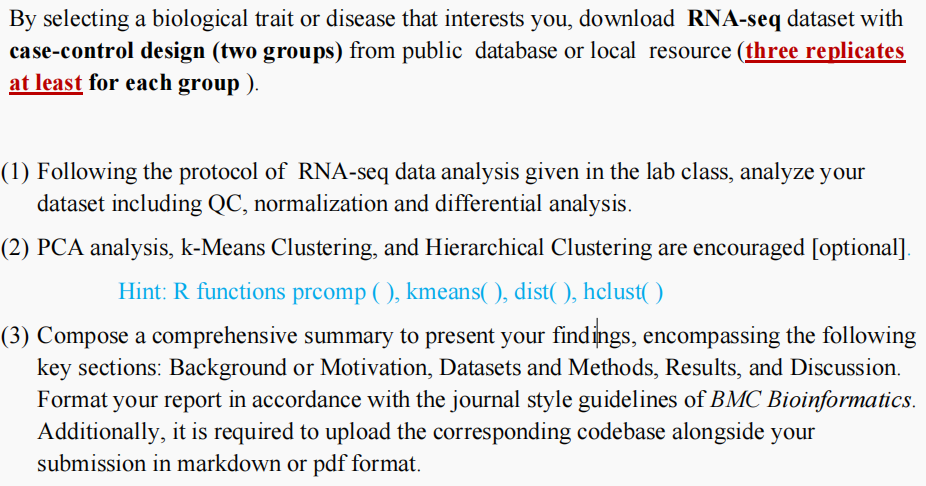

都5202年了，还需要纠结RNA-seq分析软件的选择么？

一般来说无需在软件的选择上纠结，如果数据中的信号比较强，用什么软件都应该能检测到，改变的效应也都应该能get到，不同软件分析的结果之间的区别应该也就是表现为排序前后的细节上。

整体流程最佳实践推荐软件：

能放环境的mamba install + mamba update，其余自行编译，设置全局环境变量（bash+zsh都要）

1，下载fastq数据：

* fasterq-dump：https://github.com/ncbi/sra-tools/wiki/HowTo:-fasterq-dump

2，质控：

* trim_galore：https://github.com/FelixKrueger/TrimGalore（fastqc+cutadapt的封装）

* fastp：https://github.com/OpenGene/fastp

* multiqc：https://github.com/MultiQC/MultiQC (只是看个html报告)

* 主要还是用trim-galore，或fastp，基本上都是修剪之后循环qc（递归调用），推荐循环使用fastp

3，mapping回帖比对：
    
* STAR：https://github.com/alexdobin/STAR

* HISAT2: https://daehwankimlab.github.io/hisat2/

* 推荐使用HISAT2

4，定量：

* featureCounts：https://subread.sourceforge.net/featureCounts.html
  
  如果要下载的话，是Subread套件的一部分，https://sourceforge.net/projects/subread/files/

* Salmon：https://combine-lab.github.io/salmon/（可以不mapping直接进行定量）

* Kalllisto：

* HTSeq-count

* StringTie

* 个人推荐使用featureCounts

5，差异表达分析：

* DESseq2：负二项分布

* edgeR：小样本

  优点在于可以做一对一的差异分析，没有生物学重复也可以做差异分析

* limma：大样本

* 推荐使用edgeR，其次DESseq2

一，下载公共数据

RNA-seq数据

case-control 2组

每组至少3个replicates

数据来源：

* 文献：https://pubmed.ncbi.nlm.nih.gov/30477559/

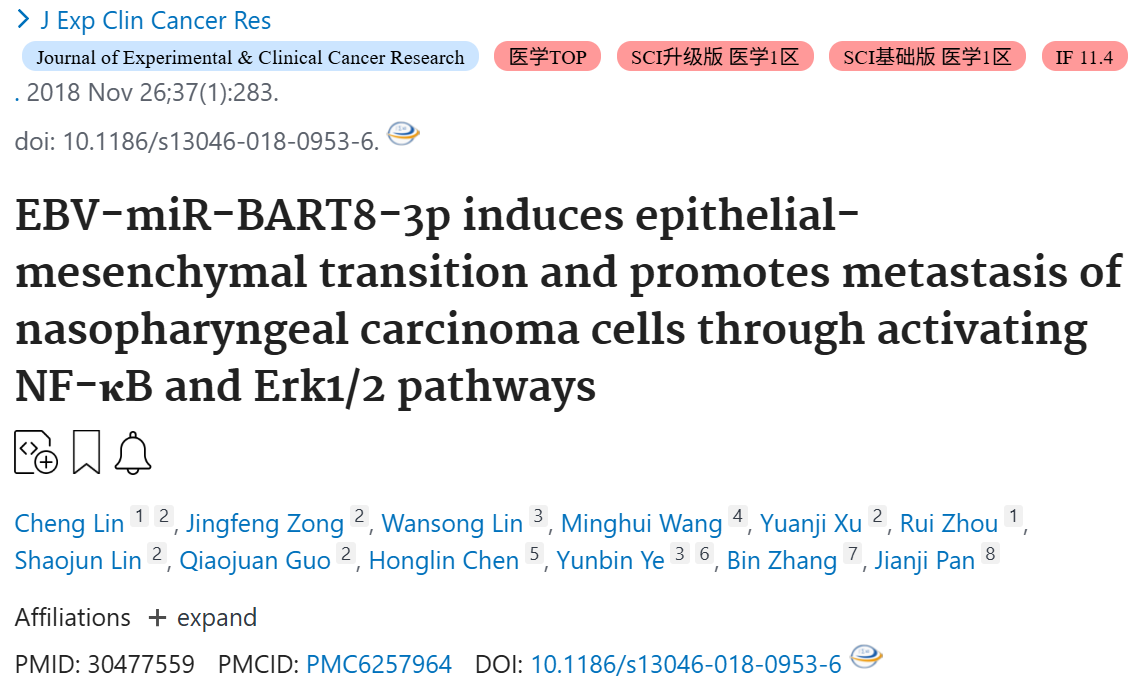

* GEO accession：GSE118719

* Platform：GPL20301	Illumina HiSeq 4000 (Homo sapiens)

* 数据描述：Transcriptomic profiling of nasopharyngeal carcinoma (NPC) and normal control samples

鼻咽癌（NPC）和正常对照样本的转录组分析，overall design是采集了 7 例 NPC 活检样本和 4 例正常鼻咽黏膜样本。从这些样本中提取总 RNA，并通过 RNA 测序进行分析。

为了工作量上方便我们分析，我们可以随机选择其中的3例NPC作为case，3例normal作为control

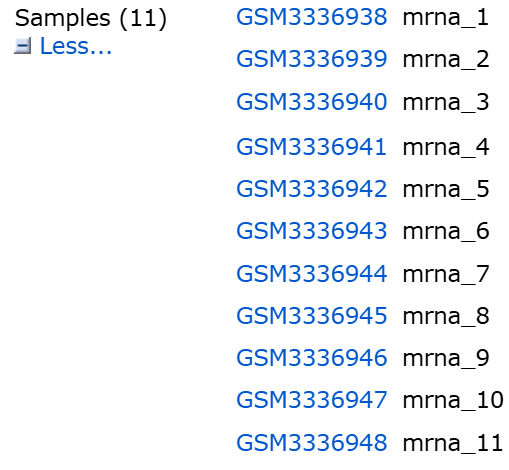

我们选择前3项：

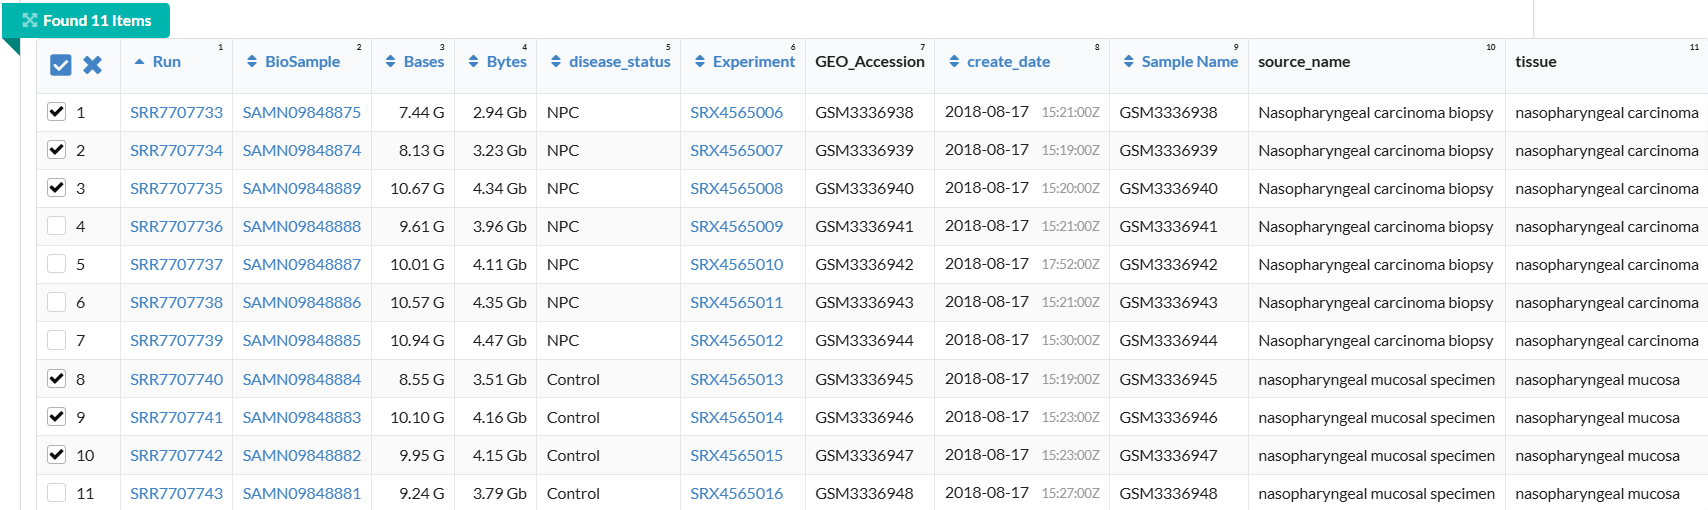

1，下载数据，数据在SRR_Acc_List.txt中

In [ ]:
import os
os.chdir("/data1/project")
os.getcwd()

'/data1/project'

In [ ]:
!ls -lh

total 15M
-rw-rw-r-- 1 nicai_zht nicai_zht   9.9K May 22 20:45 after_merge.xlsx
-rw-rw-r-- 1 nicai_zht nicai_zht   3.0K Mar 27 16:50 generate_hmm.pl
-rw-rw-r-- 1 nicai_zht nicai_zht   1.3K Mar 27 16:56 generate.pl
drwxrwxrwx 3 nicai_zht zht_bioinfo 4.0K Feb 20 22:47 hic_lung
-rw-rw-r-- 1 nicai_zht nicai_zht   1.1M May 20 18:44 hw10.ipynb
drwxrwxr-x 3 nicai_zht nicai_zht   4.0K May  8 10:28 latex
drwxrwxr-x 4 nicai_zht nicai_zht   4.0K Mar 23 13:48 omics_class
drwxrwxr-x 2 nicai_zht nicai_zht   4.0K May 22 10:18 proj2
-rw-rw-r-- 1 nicai_zht nicai_zht   590K May 24 22:36 proj2.ipynb
-rw-rw-r-- 1 nicai_zht nicai_zht    13M May 16 15:13 protein_matrix.txt
-rw-rw-r-- 1 nicai_zht nicai_zht     65 May 22 09:39 SRR_Acc_List.txt
-rw-rw-r-- 1 nicai_zht nicai_zht   2.7K May 13 20:20 test.ipynb
drwx------ 7 nicai_zht nicai_zht   4.0K May 22 09:37 ZFP_block


In [ ]:
# 01，封装成python脚本01_download_fq.py
# 优先使用subprocess.run，其次使用call；
# 如果是f string，使用shell=true，注意软件都要在环境变量中

import subprocess

# 数据下载参数设置
num_threads = 15    # 下载使用的线程数
Outdir = "/data1/project/proj2"
Sra_file = "/data1/project/SRR_Acc_List.txt"

# with打读
with open(Sra_file,"r") as sras:
    for sra in sras:
        sra = sra.strip("\n") # 去掉每行的换行符
        print(f"currently downloading {sra}\n", flush=True) # flush=True可以强制输出到终端，避免输出被缓存
        prefetch = f"prefetch {sra} --max-size 50G -O {Outdir}\n" 
        subprocess.run(prefetch,check=True,shell=True) 
         
        print (f"generating fastq for {sra}\n", flush=True)
        fasterq_dump = f"fasterq-dump {sra} -e {num_threads} -O {Outdir}\{sra}" 
        subprocess.run(fasterq_dump,check=True,shell=True)

In [ ]:
# 02，封装成shell脚本01_download_fq.sh

#!/usr/bin/bash
# 可以尝试使用zsh

num_threads=10
Out_dir="/data1/project/proj2"
Sra_file="/data1/project/SRR_Acc_List.txt"

mkdir -p $Out_dir

for sra in $(cat $Sra_file):
do
    echo "currently Downloading ${sra}\n"
    preftech ${sra} --max-size 50G -O ${Outdir}

    echo "generating fastq files from ${sra}\n"
    fasterq-dump --threads ${num_threads} -O ${Outdir}\${sra} ${sra}
done

In [ ]:
# 也可以直接封装成python函数，最后全都集成在py中

def download_fq(sra_file,num_threads,Outdir):
    """
    Args:
        sra_file: str, SRA文件路径
        num_threads: int, 下载使用的线程数
        Outdir: str, 输出目录
    """
    
    with open(sra_file,"r") as sras:
        for sra in sras:
            sra = sra.strip("\n") # 去掉每行的换行符
            print(f"currently downloading {sra}\n", flush=True)
            prefetch = f"prefetch {sra} --max-size 50G -O {Outdir}" 
            subprocess.run(prefetch,check=True,shell=True) 
            
            print (f"generating fastq for {sra}\n", flush=True)
            fasterq_dump = f"fasterq-dump {sra} -e {num_threads} -O {Outdir}\{sra}" 
            subprocess.run(fasterq_dump,check=True,shell=True)

In [ ]:
# while read在shell中使用也可以

In [ ]:
# tmux new -s RNA
# 再挂后台
!nohup python3 01_download_fq.py &> 01_download_fq.log &
!nohup bash 01_download_fq.sh &> 01_download_fq.log &  # 可以使用zsh

2，对fq文件的质控qc，直到符合初步需求

In [ ]:
# fastp --help &> fastp.txt
import subprocess
q=20 # 质控Q20标准，＜20即低质量
u=30 # 限制允许存在的低质量碱基比例
num_threads=15
Sra_file="/data1/project/SRR_Acc_List.txt"
rawfq_dir="/data1/project/proj2"


with open(Sra_file,"r") as sras:
    for sra in sras:
        sra = sra.strip("\n") # 去掉每行的换行符

        print(f"currently fastp quality control for {sra}\n", flush=True)
        fastp_command = f"""
        fastp -i {rawfq_dir}/{sra}_1.fastq 
            -o {rawfq_dir}/{sra}_1_clean.fastq    
                -I {rawfq_dir}/{sra}_2.fastq 
                    -O {rawfq_dir}/{sra}_2_clean.fastq 
                        -h {rawfq_dir}/{sra}_fastp.html 
                            -j {rawfq_dir}/{sra}_fastp.json
                                -q {q} -u {u} -w {num_threads}""".replace("\n","") 
        # 此处使用"""更加清晰换行，最后必须用.replace("\n","")去掉换行符
        # 注意-j是因为multiqc需要json文件
        subprocess.run(fastp_command,check=True,shell=True)

In [ ]:
!nohup python3 02_fastp.py &> 02_fastp.log &
!multiqc .   # 放在json文件目录下

查看相应的质控结果，可以从log中看，也可以从fastp的html中看

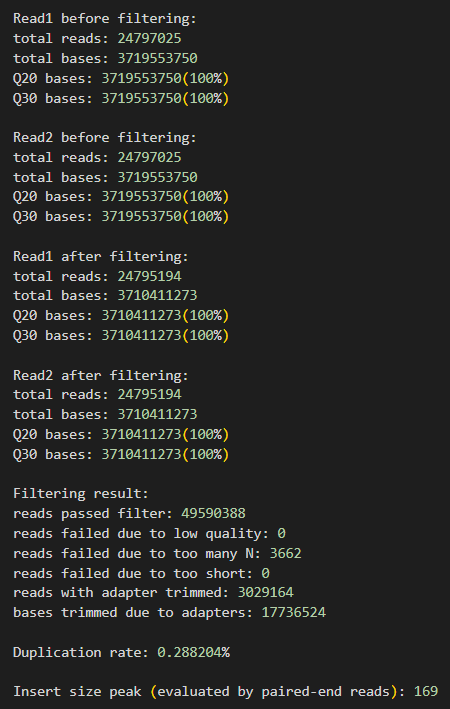

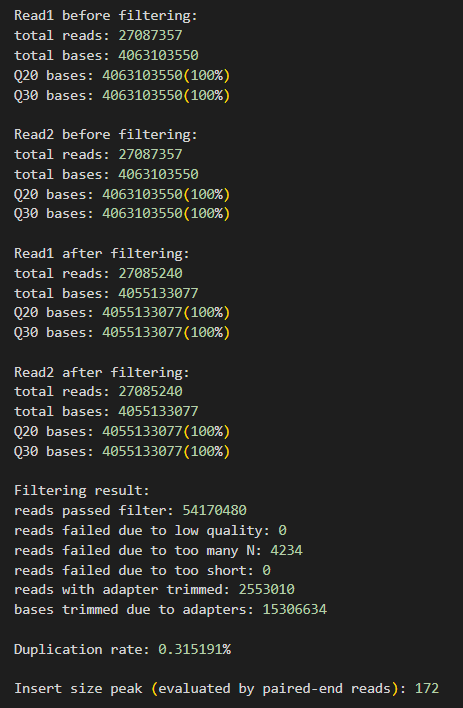

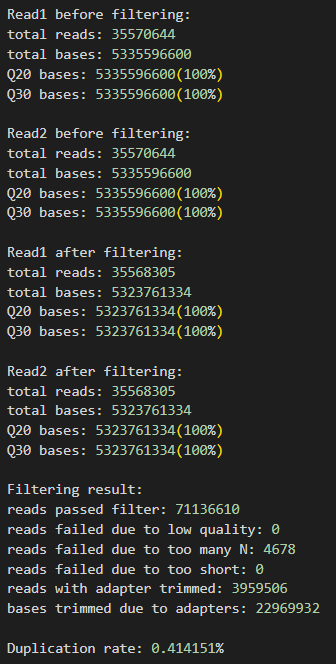

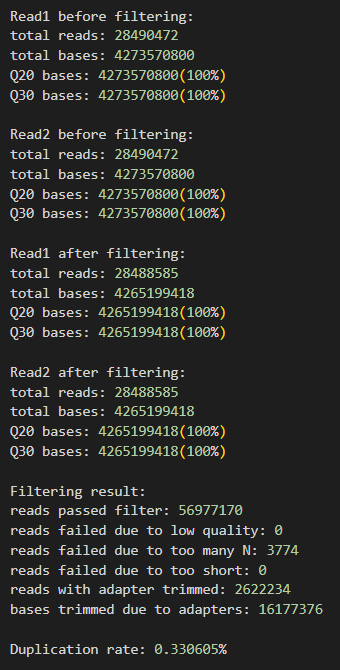

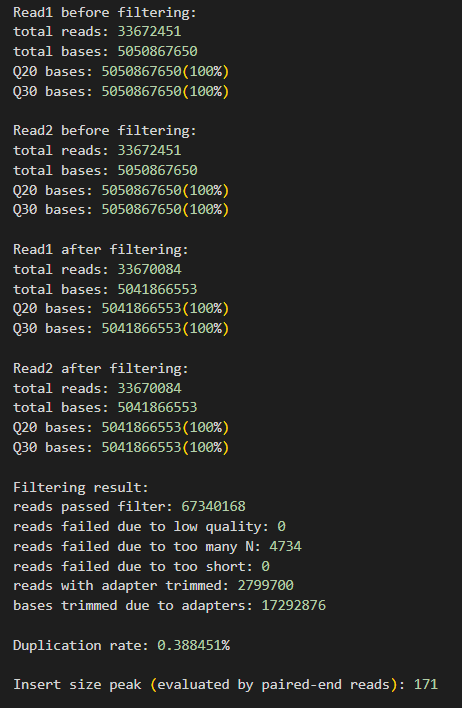

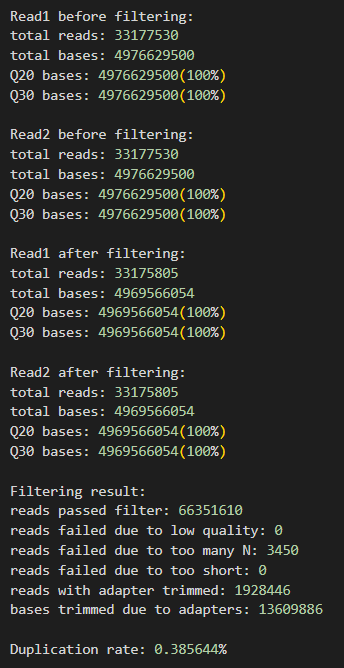

从日志中看数据还是挺好的，测序质量不错，也许是上传数据的人在上传数据之前就顺便处理好了

fastp的质控报告相比fastqc有点贫乏，内容有点少，

3，参考基因组比对：


（1）参考基因组构建索引index：

hg系列是UCSC的叫法，GRCh系列是NCBI和ENSEMBL的叫法，此处使用ucsc的hg38

此处使用hisat2，相应index就到官网中下载https://daehwankimlab.github.io/hisat2/download/，总之参考基因组的处理数据对应你的比对工具

In [ ]:
!wget https://genome-idx.s3.amazonaws.com/hisat/hg38_genome.tar.gz
!curl -O https://genome-idx.s3.amazonaws.com/hisat/hg38_genome.tar.gz

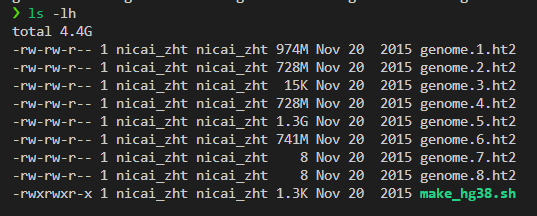

和DNA比对中经典的bowtie2获取的index格式稍有不同（命令其实很相似），当然index我们可以自己获取基因组fa文件之后再构建；

自定义的话，我们可以对基因组fa中的一些异常chr去除，只保留chr1-22+XY，

当然直接下载比对软件中自构建的index文件也好

（2）比对参考基因组

In [ ]:
import subprocess

number_threads=15
Ref_Genome_dir="/home/nicai_zht/ref_data/hg38/genome"
Sra_file="/data1/project/SRR_Acc_List.txt"
cleanfq_dir="/data1/project/proj2"

with open(Sra_file,"r") as sras:
    for sra in sras:
        sra = sra.strip("\n")
        print(f"currently hisat2 mapping for {sra}\n",flush=True)
        hisat2_command = f"""
        hisat2 -p {number_threads} -x {Ref_Genome_dir} 
            -1 {cleanfq_dir}/{sra}_1_clean.fastq 
                -2 {cleanfq_dir}/{sra}_2_clean.fastq
                    -S {cleanfq_dir}/{sra}_align.sam
                        --summary-file {cleanfq_dir}/{sra}_align_summary
                            """.replace("\n","")
        subprocess.run(hisat2_command,check=True,shell=True)
        
        # 因为samtools转换bam以及sort一般不需要中间文件，在shell中的管道写法，在python中也可以
        print(f"currently samtools converting and sort sam for {sra}\n",flush=True)
        sam2bam_sort = f"samtools view -@ {number_threads} -bS {cleanfq_dir}/{sra}_align.sam | samtools sort -@ {number_threads} -o {cleanfq_dir}/{sra}_align_sorted.bam"
        subprocess.run(sam2bam_sort,check=True,shell=True)

In [ ]:
!nohup python3 03_hisat2_mapping.py &> 03_hisat2_mapping.log &

然后也是看回帖比对的一些统计量：

按照以下条目信息，对应归纳：

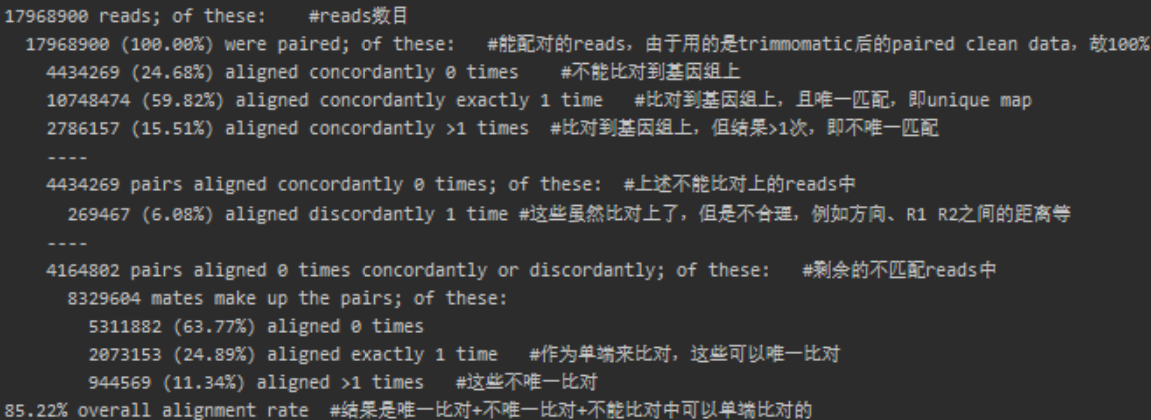

可以看log，也可以看--summary-file指定输出的文件

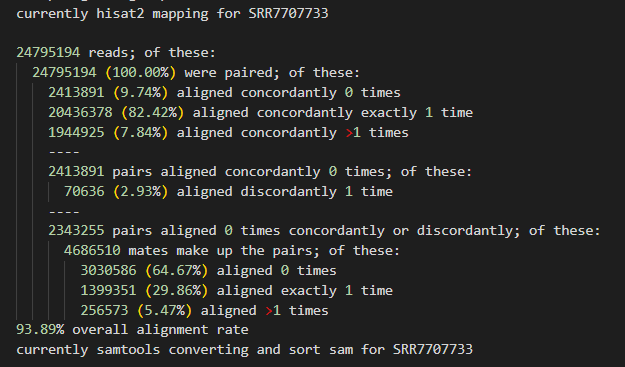

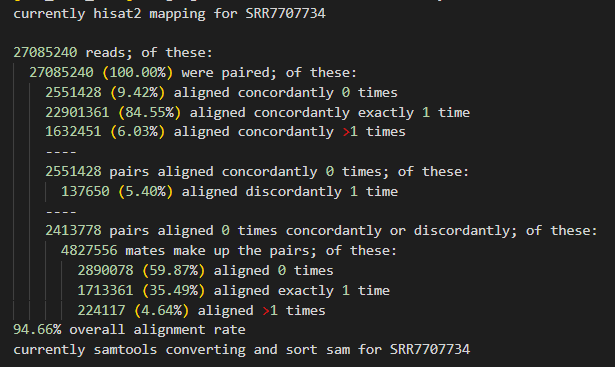

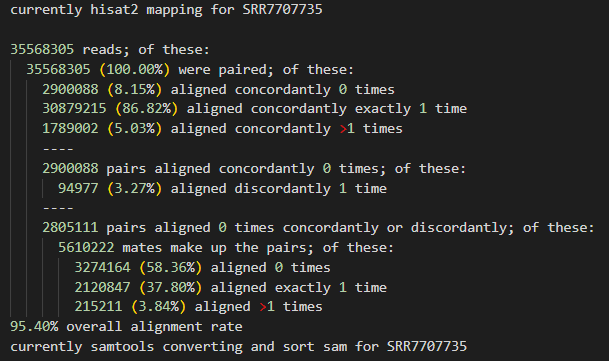

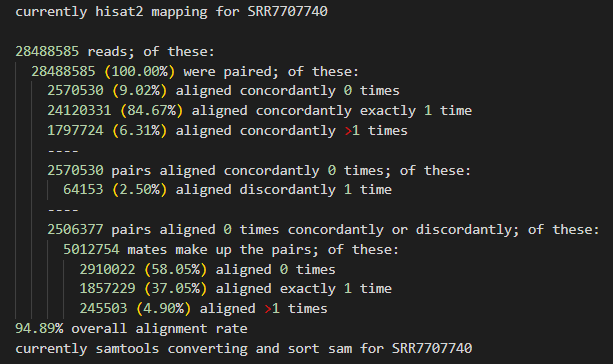

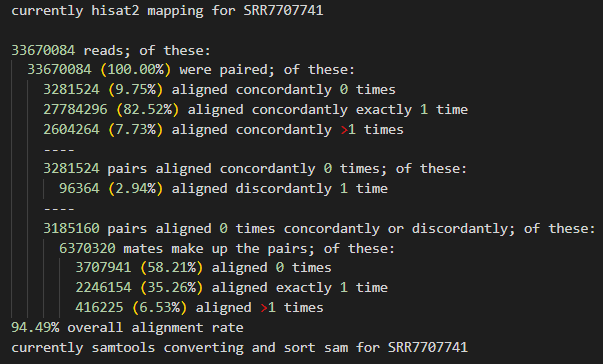

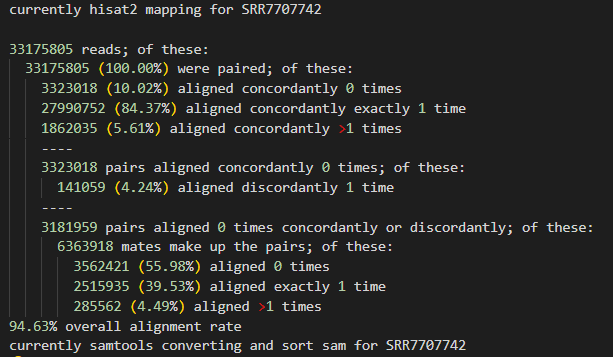

4，获取表达定量文件

因为前面使用了hg38的参考基因组，此处定量需要基因组注释文件gtf，可以到ucsc上下载，或者是Gencode上等，此处到ucsc上下载，

https://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/genes/

此处选择https://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/genes/hg38.knownGene.gtf.gz，即knownGene

In [ ]:
import subprocess
import glob

number_threads=15
annotation="/home/nicai_zht/ref_data/hg38.knownGene.gtf"
cleanfq_dir="/data1/project/proj2"
deg_dir="/data1/project/proj2/Deg"

# 收集所有sorted bam文件路径
bam_files = glob.glob(f"{cleanfq_dir}/*_align_sorted.bam")
bam_files_str = " ".join(bam_files) # 将所有bam文件路径拼接成一个字符串

print(f"currently featureCounts Expression Quantification for all sorted bam\n",flush=True)
featureCounts_command = f"""
    featureCounts -p --countReadPairs -T {number_threads}
        -t exon -g gene_id 
        -a {annotation}
        -o {deg_dir}/all_counts.txt
        {bam_files_str}
                    """.replace("\n","")
# -p和--countReadPairs是配对测序的参数，paired end
subprocess.run(featureCounts_command,check=True,shell=True)

In [ ]:
!nohup python3 04_featureCounts.py &> 04_featureCounts.log &

运行的日志：

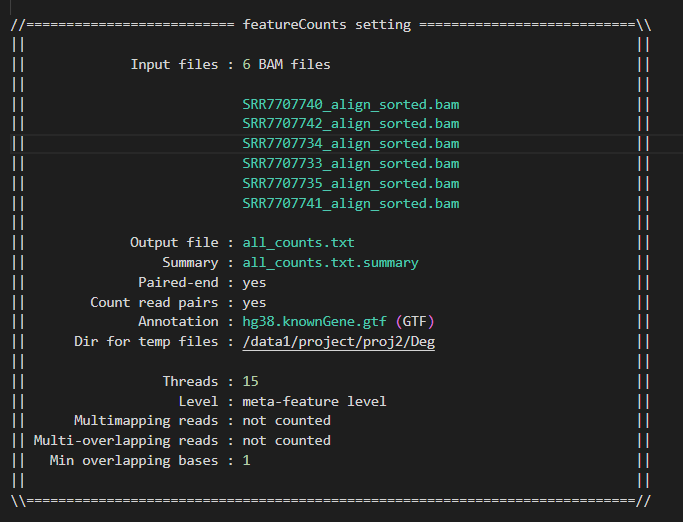

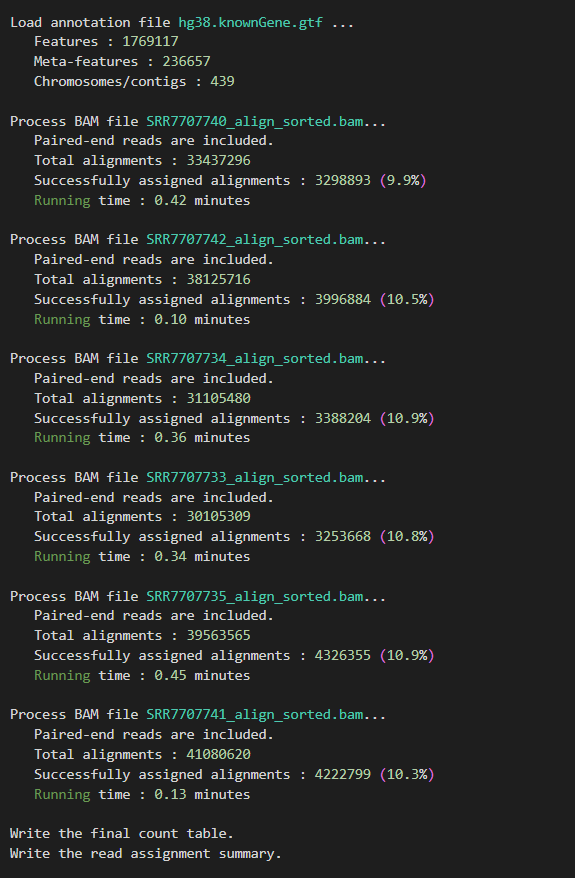

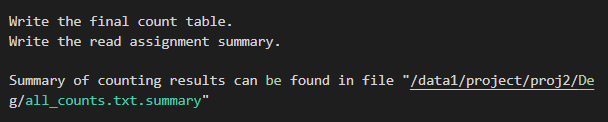

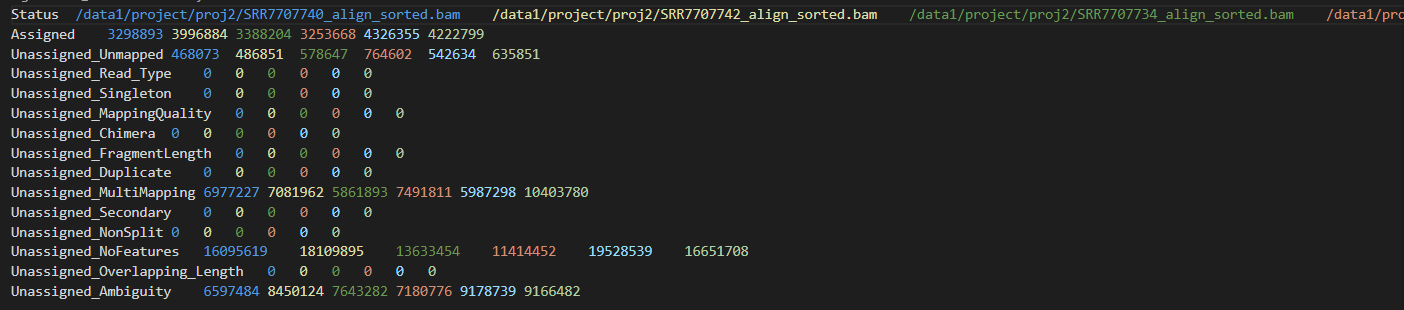

In [ ]:
!head -n 10 /data1/project/proj2/Deg/all_counts.txt

# Program:featureCounts v2.1.1; Command:"featureCounts" "-p" "--countReadPairs" "-T" "15" "-t" "exon" "-g" "gene_id" "-a" "/home/nicai_zht/ref_data/hg38.knownGene.gtf" "-o" "/data1/project/proj2/Deg/all_counts.txt" "/data1/project/proj2/SRR7707740_align_sorted.bam" "/data1/project/proj2/SRR7707742_align_sorted.bam" "/data1/project/proj2/SRR7707734_align_sorted.bam" "/data1/project/proj2/SRR7707733_align_sorted.bam" "/data1/project/proj2/SRR7707735_align_sorted.bam" "/data1/project/proj2/SRR7707741_align_sorted.bam" 
Geneid	Chr	Start	End	Strand	Length	/data1/project/proj2/SRR7707740_align_sorted.bam	/data1/project/proj2/SRR7707742_align_sorted.bam	/data1/project/proj2/SRR7707734_align_sorted.bam	/data1/project/proj2/SRR7707733_align_sorted.bam	/data1/project/proj2/SRR7707735_align_sorted.bam	/data1/project/proj2/SRR7707741_align_sorted.bam
ENST00000456328.2	chr1;chr1;chr1	11869;12613;13221	12227;12721;14409	+;+;+	1657	2	1	0	0	0	1
ENST00000619216.1	chr1	17369	17436	-	68	4	9	13	5	13	11
EN

5，对表达定量值进行标准化normalization（在R中，在python中也可以）

In [ ]:
# rpy2容易崩，谨慎使用，还是用R内核
import rpy2
%load_ext rpy2.ipython

%%R

During startup - Warning messages:
1: package ‘methods’ was built under R version 4.4.3 
2: package ‘datasets’ was built under R version 4.4.3 
3: package ‘utils’ was built under R version 4.4.3 
4: package ‘grDevices’ was built under R version 4.4.3 
5: package ‘graphics’ was built under R version 4.4.3 
6: package ‘stats’ was built under R version 4.4.3 


In [3]:
library(GenomicFeatures) # 建议用mamba装
library(txdbmaker)   # BiocManager::install("txdbmaker",force=TRUE)，主要是其中的makeTxDbFromGFF函数
library(DESeq2) # BiocManager::install("DESeq2",force=TRUE)
# library(tidyverse) 

In [4]:
txdb <- makeTxDbFromGFF("/home/nicai_zht/ref_data/hg38.knownGene.gtf",format="gtf")

Import genomic features from the file as a GRanges object ... 
OK

Prepare the 'metadata' data frame ... 
OK

Make the TxDb object ... 
Warning message in .get_cds_IDX(mcols0$type, mcols0$phase):
“The "phase" metadata column contains non-NA values for features of type
  stop_codon. This information was ignored.”
OK



In [7]:
exons_gene <- exonsBy(txdb, by = "gene")

In [8]:
Length <- lapply(exons_gene,function(x){sum(width(GenomicRanges::reduce(x)))}) # 注意GenomicRanges的reduce和tidyverse中的reduce不一样，不要混用会报错

In [9]:
Length <-t(as.data.frame(Length))

In [10]:
rownames(Length)<-gsub("\\.(\\.?\\d*)","",rownames(Length))

In [ ]:
txdb <- makeTxDbFromGFF("/home/nicai_zht/ref_data/hg38.knownGene.gtf",format="gtf")
exons_gene <- exonsBy(txdb, by = "gene")
Length <- lapply(exons_gene,function(x){sum(width(reduce(x)))})
Length <-t(as.data.frame(Length))
rownames(Length)<-gsub("\\.(\\.?\\d*)","",rownames(Length))

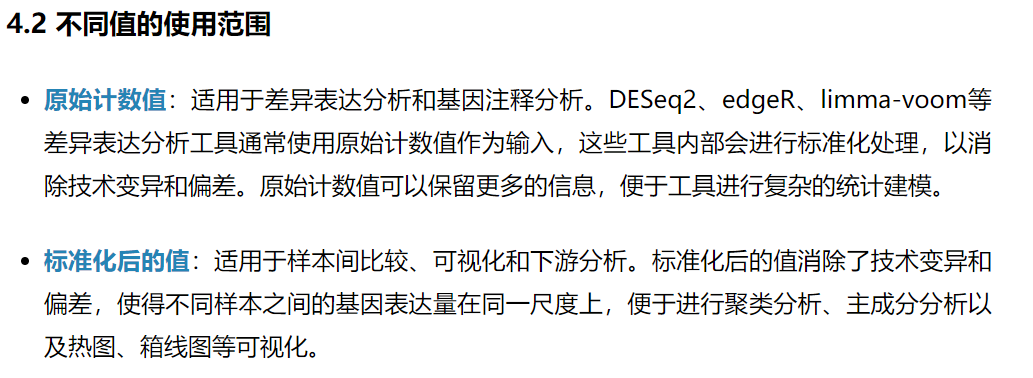

In [12]:
deg_dir="/data1/project/proj2/Deg"
setwd(deg_dir)
# 读取featureCounts的结果
# 注意这里的counts.txt是featureCounts的结果
input_data <- read.table("/data1/project/proj2/Deg/all_counts.txt",header = TRUE,row.names =1,quote="")

In [15]:
head(input_data)
colnames(input_data)

,Chr,Start,End,Strand,Length,X.data1.project.proj2.SRR7707740_align_sorted.bam,X.data1.project.proj2.SRR7707742_align_sorted.bam,X.data1.project.proj2.SRR7707734_align_sorted.bam,X.data1.project.proj2.SRR7707733_align_sorted.bam,X.data1.project.proj2.SRR7707735_align_sorted.bam,X.data1.project.proj2.SRR7707741_align_sorted.bam
,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENST00000456328.2,chr1;chr1;chr1,11869;12613;13221,12227;12721;14409,+;+;+,1657,2,1,0,0,0,1
ENST00000619216.1,chr1,17369,17436,-,68,4,9,13,5,13,11
ENST00000473358.1,chr1;chr1;chr1,29554;30564;30976,30039;30667;31097,+;+;+,712,0,0,0,0,0,0
ENST00000469289.1,chr1;chr1,30267;30976,30667;31109,+;+,535,0,0,0,0,0,0
ENST00000607096.1,chr1,30366,30503,+,138,0,0,0,0,0,0
ENST00000417324.1,chr1;chr1;chr1,34554;35277;35721,35174;35481;36081,-;-;-,1187,0,0,0,0,0,0


[1] "Chr"                                              
 [2] "Start"                                            
 [3] "End"                                              
 [4] "Strand"                                           
 [5] "Length"                                           
 [6] "X.data1.project.proj2.SRR7707740_align_sorted.bam"
 [7] "X.data1.project.proj2.SRR7707742_align_sorted.bam"
 [8] "X.data1.project.proj2.SRR7707734_align_sorted.bam"
 [9] "X.data1.project.proj2.SRR7707733_align_sorted.bam"
[10] "X.data1.project.proj2.SRR7707735_align_sorted.bam"
[11] "X.data1.project.proj2.SRR7707741_align_sorted.bam"

In [16]:
input_data <- as.matrix(input_data[,6:11])

In [17]:
input_data

,X.data1.project.proj2.SRR7707740_align_sorted.bam,X.data1.project.proj2.SRR7707742_align_sorted.bam,X.data1.project.proj2.SRR7707734_align_sorted.bam,X.data1.project.proj2.SRR7707733_align_sorted.bam,X.data1.project.proj2.SRR7707735_align_sorted.bam,X.data1.project.proj2.SRR7707741_align_sorted.bam
ENST00000456328.2,2,1,0,0,0,1
ENST00000619216.1,4,9,13,5,13,11
ENST00000473358.1,0,0,0,0,0,0
ENST00000469289.1,0,0,0,0,0,0
ENST00000607096.1,0,0,0,0,0,0
ENST00000417324.1,0,0,0,0,0,0
ENST00000461467.1,0,0,0,0,0,0
ENST00000642116.1,0,0,0,0,0,0
A0A2U3U0J3,0,0,0,1,0,0
ENST00000466430.5,1,0,0,0,0,0


In [18]:
rownames(input_data)<-gsub("\\.(\\.?\\d*)","",rownames(input_data))

In [19]:
input_data

,X.data1.project.proj2.SRR7707740_align_sorted.bam,X.data1.project.proj2.SRR7707742_align_sorted.bam,X.data1.project.proj2.SRR7707734_align_sorted.bam,X.data1.project.proj2.SRR7707733_align_sorted.bam,X.data1.project.proj2.SRR7707735_align_sorted.bam,X.data1.project.proj2.SRR7707741_align_sorted.bam
ENST00000456328,2,1,0,0,0,1
ENST00000619216,4,9,13,5,13,11
ENST00000473358,0,0,0,0,0,0
ENST00000469289,0,0,0,0,0,0
ENST00000607096,0,0,0,0,0,0
ENST00000417324,0,0,0,0,0,0
ENST00000461467,0,0,0,0,0,0
ENST00000642116,0,0,0,0,0,0
A0A2U3U0J3,0,0,0,1,0,0
ENST00000466430,1,0,0,0,0,0


In [20]:
input_data <- as.data.frame(cbind(input_data[match(intersect(rownames(input_data),rownames(Length)),rownames(input_data)),],Length[match(intersect(rownames(input_data),rownames(Length)),rownames(Length)),,drop=F]) )

In [22]:
input_data 

,X.data1.project.proj2.SRR7707740_align_sorted.bam,X.data1.project.proj2.SRR7707742_align_sorted.bam,X.data1.project.proj2.SRR7707734_align_sorted.bam,X.data1.project.proj2.SRR7707733_align_sorted.bam,X.data1.project.proj2.SRR7707735_align_sorted.bam,X.data1.project.proj2.SRR7707741_align_sorted.bam,V7
,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENST00000456328,2,1,0,0,0,1,1657
ENST00000619216,4,9,13,5,13,11,68
ENST00000473358,0,0,0,0,0,0,712
ENST00000469289,0,0,0,0,0,0,535
ENST00000607096,0,0,0,0,0,0,138
ENST00000417324,0,0,0,0,0,0,1187
ENST00000461467,0,0,0,0,0,0,590
ENST00000642116,0,0,0,0,0,0,1414
A0A2U3U0J3,0,0,0,1,0,0,2618


In [23]:
colnames(input_data)[dim(input_data)[2]]<-"Length"

In [ ]:
deg_dir="/data1/project/proj2/Deg"
setwd(deg_dir)
# 读取featureCounts的结果
# 注意这里的counts.txt是featureCounts的结果
input_data <- read.table("/data1/project/proj2/Deg/all_counts.txt",header = TRUE,row.names =1,quote="")
input_data <- as.matrix(input_data[,6:11])
rownames(input_data)<-gsub("\\.(\\.?\\d*)","",rownames(input_data))
input_data <- as.data.frame(cbind(input_data[match(intersect(rownames(input_data),rownames(Length)),rownames(input_data)),],Length[match(intersect(rownames(input_data),rownames(Length)),rownames(Length)),,drop=F]) )
colnames(input_data)[dim(input_data)[2]]<-"Length" # 最后1列命名

In [24]:
#TPM
kb <- input_data$Length / 1000
countdata <- input_data[,1:(dim(input_data)[2]-1)]
rpk <- countdata / kb
tpm <- t(t(rpk)/colSums(rpk) * 1000000)
head(tpm)
write.table(tpm,file="Expression_TPM.txt",sep="\t",quote=F)

,X.data1.project.proj2.SRR7707740_align_sorted.bam,X.data1.project.proj2.SRR7707742_align_sorted.bam,X.data1.project.proj2.SRR7707734_align_sorted.bam,X.data1.project.proj2.SRR7707733_align_sorted.bam,X.data1.project.proj2.SRR7707735_align_sorted.bam,X.data1.project.proj2.SRR7707741_align_sorted.bam
ENST00000456328,0.5323916,0.2307676,0.00000,0.00000,0.00000,0.1874046
ENST00000619216,25.9462615,50.6093765,86.95676,33.64205,69.65647,50.2326943
ENST00000473358,0.0000000,0.0000000,0.00000,0.00000,0.00000,0.0000000
ENST00000469289,0.0000000,0.0000000,0.00000,0.00000,0.00000,0.0000000
ENST00000607096,0.0000000,0.0000000,0.00000,0.00000,0.00000,0.0000000
ENST00000417324,0.0000000,0.0000000,0.00000,0.00000,0.00000,0.0000000


In [25]:
#FPKM
fpkm <- t(t(rpk)/colSums(countdata) * 10^9)
head(fpkm)
write.table(fpkm,file="Expression_FPKM.txt",sep="\t",quote=F)

,X.data1.project.proj2.SRR7707740_align_sorted.bam,X.data1.project.proj2.SRR7707742_align_sorted.bam,X.data1.project.proj2.SRR7707734_align_sorted.bam,X.data1.project.proj2.SRR7707733_align_sorted.bam,X.data1.project.proj2.SRR7707735_align_sorted.bam,X.data1.project.proj2.SRR7707741_align_sorted.bam
ENST00000456328,365.8805,150.9927,0.00,0.00,0.00,142.9148
ENST00000619216,17831.2935,33114.0311,56424.13,22598.93,44188.81,38307.4605
ENST00000473358,0.0000,0.0000,0.00,0.00,0.00,0.0000
ENST00000469289,0.0000,0.0000,0.00,0.00,0.00,0.0000
ENST00000607096,0.0000,0.0000,0.00,0.00,0.00,0.0000
ENST00000417324,0.0000,0.0000,0.00,0.00,0.00,0.0000


In [26]:
#FPKM to TPM
fpkm_to_tpm = t(t(fpkm)/colSums(fpkm))*10^6
head(fpkm_to_tpm)

,X.data1.project.proj2.SRR7707740_align_sorted.bam,X.data1.project.proj2.SRR7707742_align_sorted.bam,X.data1.project.proj2.SRR7707734_align_sorted.bam,X.data1.project.proj2.SRR7707733_align_sorted.bam,X.data1.project.proj2.SRR7707735_align_sorted.bam,X.data1.project.proj2.SRR7707741_align_sorted.bam
ENST00000456328,0.5323916,0.2307676,0.00000,0.00000,0.00000,0.1874046
ENST00000619216,25.9462615,50.6093765,86.95676,33.64205,69.65647,50.2326943
ENST00000473358,0.0000000,0.0000000,0.00000,0.00000,0.00000,0.0000000
ENST00000469289,0.0000000,0.0000000,0.00000,0.00000,0.00000,0.0000000
ENST00000607096,0.0000000,0.0000000,0.00000,0.00000,0.00000,0.0000000
ENST00000417324,0.0000000,0.0000000,0.00000,0.00000,0.00000,0.0000000


6，差异表达分析

In [27]:
deg_dir="/data1/project/proj2/Deg"
setwd(deg_dir)
# 读取featureCounts的结果
# 注意这里的counts.txt是featureCounts的结果
input_data <- read.table("/data1/project/proj2/Deg/all_counts.txt",header = TRUE,row.names =1,quote="")
input_data <- as.matrix(input_data[,6:11])

In [ ]:
input_data 

,X.data1.project.proj2.SRR7707740_align_sorted.bam,X.data1.project.proj2.SRR7707742_align_sorted.bam,X.data1.project.proj2.SRR7707734_align_sorted.bam,X.data1.project.proj2.SRR7707733_align_sorted.bam,X.data1.project.proj2.SRR7707735_align_sorted.bam,X.data1.project.proj2.SRR7707741_align_sorted.bam
ENST00000456328.2,2,1,0,0,0,1
ENST00000619216.1,4,9,13,5,13,11
ENST00000473358.1,0,0,0,0,0,0
ENST00000469289.1,0,0,0,0,0,0
ENST00000607096.1,0,0,0,0,0,0
ENST00000417324.1,0,0,0,0,0,0
ENST00000461467.1,0,0,0,0,0,0
ENST00000642116.1,0,0,0,0,0,0
A0A2U3U0J3,0,0,0,1,0,0
ENST00000466430.5,1,0,0,0,0,0


In [29]:
colnames(input_data) <- c("40", "42", "34", "33", "35", "41")

In [31]:
input_data <- input_data[,c("40","41","42","33","34","35")]

In [32]:
input_data

,40,41,42,33,34,35
ENST00000456328.2,2,1,1,0,0,0
ENST00000619216.1,4,11,9,5,13,13
ENST00000473358.1,0,0,0,0,0,0
ENST00000469289.1,0,0,0,0,0,0
ENST00000607096.1,0,0,0,0,0,0
ENST00000417324.1,0,0,0,0,0,0
ENST00000461467.1,0,0,0,0,0,0
ENST00000642116.1,0,0,0,0,0,0
A0A2U3U0J3,0,0,0,1,0,0
ENST00000466430.5,1,0,0,0,0,0


In [34]:
condition <- factor(c(rep("control",3),rep("case",3)))
coldata <- data.frame(row.names=colnames(input_data),condition)
dds <- DESeqDataSetFromMatrix(countData =input_data,colData=coldata,design=~condition)
dds1 <- dds[ rowSums(counts(dds)) > 1, ]
dds2 <- DESeq(dds1)
res_0.05 <- results(dds2,alpha=0.05)
res_0.05 <- res_0.05[order(res_0.05$padj),]
resdata_0.05 <- merge(as.data.frame(res_0.05),as.data.frame(counts(dds2,normalized=TRUE)),by="row.names",sort=FALSE)
write.csv(resdata_0.05,file="diff_gene_whole.csv",quote=F,row.names=F)
diff_gene_deseq2 <-subset(resdata_0.05, padj < 0.05 & abs(log2FoldChange) > 1)
write.csv(diff_gene_deseq2,file= "DEG.csv",quote=F,row.names=F)

  it appears that the last variable in the design formula, 'condition',
  has a factor level, 'control', which is not the reference level. we recommend
  to use factor(...,levels=...) or relevel() to set this as the reference level
  before proceeding. for more information, please see the 'Note on factor levels'
  in vignette('DESeq2').

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [38]:
library(tidyverse)
diff_gene_deseq2 %>% select(Row.names, log2FoldChange, padj) %>%
  filter(padj < 0.05 & log2FoldChange > 1) %>%
  write_csv(file = "DEG_up.csv")
diff_gene_deseq2 %>% select(Row.names, log2FoldChange, padj) %>%
  filter(padj < 0.05 & log2FoldChange < -1) %>%
  write_csv(file = "DEG_down.csv")

做富集分析，可以用clusterprofiler，GSEA；

也可以使用过表征分析的metascape

上调的：

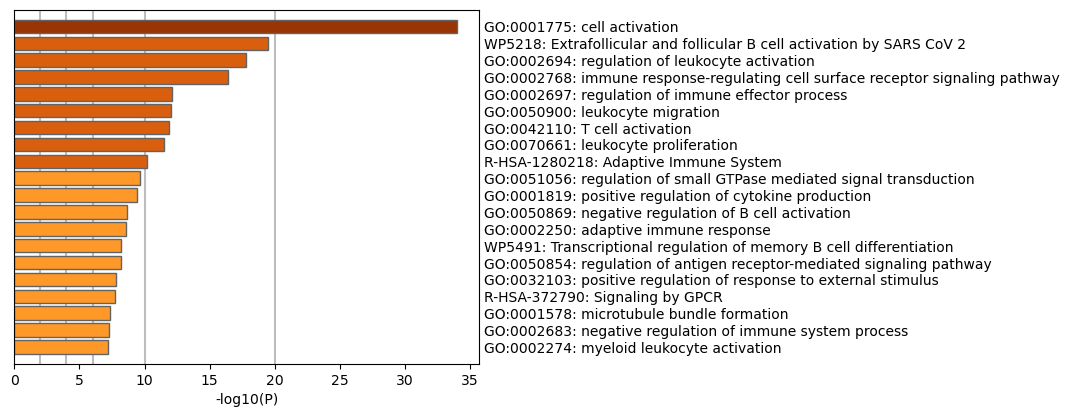

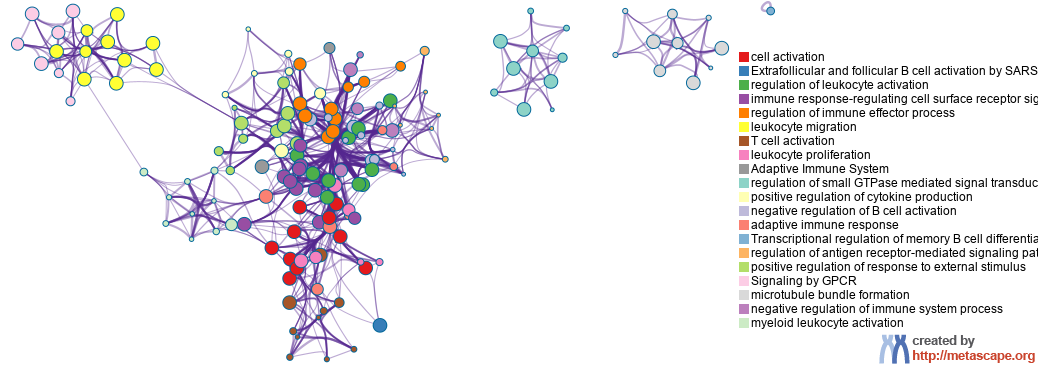

蛋白质的MCODE网络：

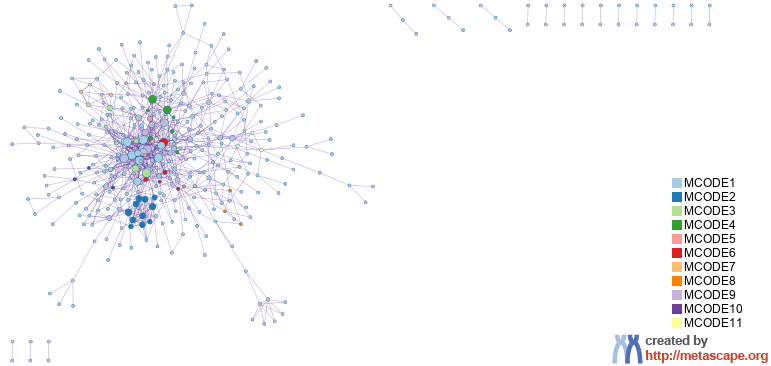

下调的：

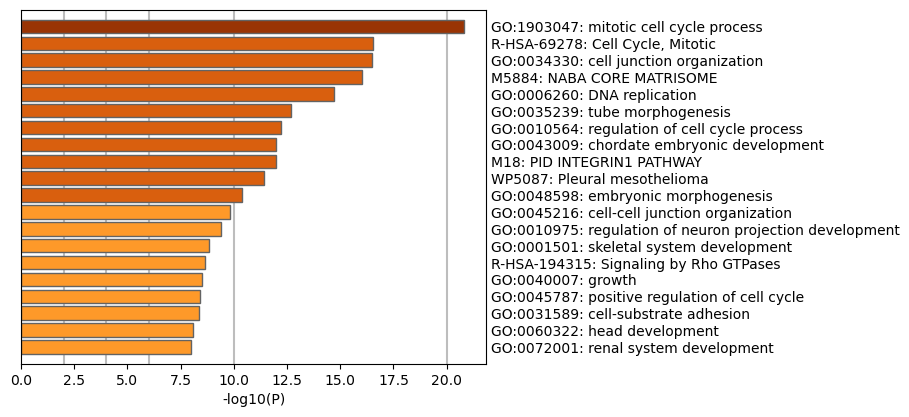

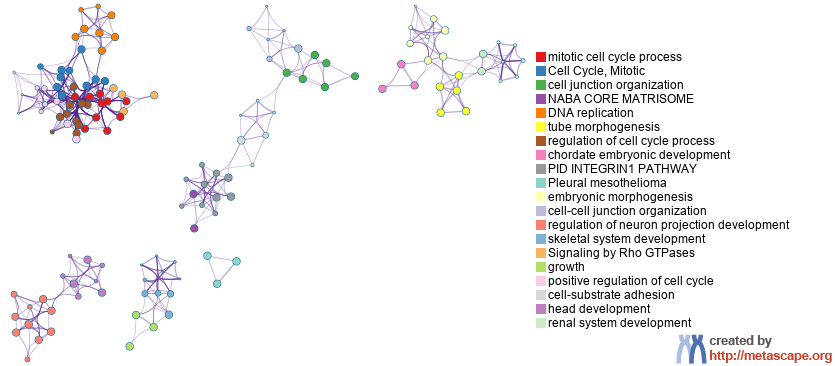


聚类，更多的是验证数据分组是否科学，层次聚类以及PCA是检测DEG分析前的批次效应

如果是大队列，TCGA中的数据，倒是可以做一做层次聚类

WGCNA和富集分析是一般的下游bul-RNA分析环节